100%|██████████| 170M/170M [00:13<00:00, 12.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch: 1/200 | Train Loss: 3.2296, Train Acc: 19.14% | Test Loss: 1.9486, Test Acc: 31.99% | Sparsity: 0.00
Epoch: 2/200 | Train Loss: 1.9757, Train Acc: 30.32% | Test Loss: 1.8244, Test Acc: 37.07% | Sparsity: 0.00
Epoch: 3/200 | Train Loss: 1.8462, Train Acc: 36.57% | Test Loss: 1.6684, Test Acc: 44.74% | Sparsity: 0.01
Epoch: 4/200 | Train Loss: 1.7287, Train Acc: 42.77% | Test Loss: 1.6891, Test Acc: 45.47% | Sparsity: 0.01
Epoch: 5/200 | Train Loss: 1.6158, Train Acc: 48.05% | Test Loss: 1.5087, Test Acc: 53.65% | Sparsity: 0.02
Epoch: 6/200 | Train Loss: 1.5175, Train Acc: 53.17% | Test Loss: 1.4935, Test Acc: 55.42% | Sparsity: 0.02
Epoch: 7/200 | Train Loss: 1.4243, Train Acc: 57.75% | Test Loss: 1.3162, Test Acc: 63.73% | Sparsity: 0.02
Epoch: 8/200 | Train Loss: 1.3450, Train Acc: 61.80% | Test Loss: 1.2484, Test Acc: 66.91% | Sparsity: 0.03
Epoch: 9/200 | Train Loss: 1.2789, Train Acc: 6

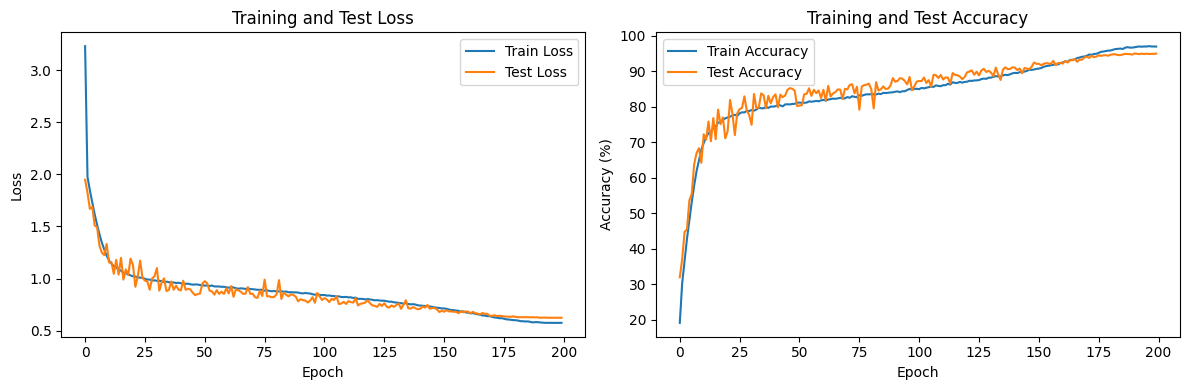


Final Results:
Final Training Loss: 0.5753
Final Test Loss: 0.6238
Final Training Accuracy: 96.90%
Final Test Accuracy: 94.91%


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# Define the basic block for ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define ResNet
class DynamicSparseResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(DynamicSparseResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

        # Dictionary to store importance scores
        self.importance_scores = {}

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))  # Output: 32x32
        out = self.layer1(out)  # Output: 32x32
        out = self.layer2(out)  # Output: 16x16
        out = self.layer3(out)  # Output: 8x8
        out = self.layer4(out)  # Output: 4x4
        out = F.avg_pool2d(out, 4)  # Output: 1x1
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return DynamicSparseResNet(BasicBlock, [2, 2, 2, 2])

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_normal_(
                m.weight, mode='fan_out', nonlinearity='relu'
            )
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

def apply_dynamic_supermask(model, sparsity_rate):
    masks = {}
    for name, param in model.named_parameters():
        if 'weight' in name:
            # Flatten weights and calculate threshold
            weight_flat = param.data.abs().flatten()
            k = int(weight_flat.shape[0] * (1 - sparsity_rate))
            if k == 0:
                threshold = torch.max(weight_flat) + 1
            else:
                threshold = torch.topk(
                    weight_flat, k, largest=True, sorted=True
                )[0][-1]
            # Create mask
            mask = (param.data.abs() >= threshold).float()
            masks[name] = mask.view(param.size()).to(param.device)
    return masks

def dynamic_weight_update(model, masks):
    for name, param in model.named_parameters():
        if 'weight' in name and param.grad is not None:
            mask = masks[name]
            param.grad.data.mul_(mask)

def train_with_dynamic_pruning(
    model, train_loader, test_loader, epochs=200, device='cuda'
):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs
    )

    initial_sparsity = 0.0
    final_sparsity = 0.8
    sparsity_increment = (final_sparsity - initial_sparsity) / epochs

    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []

    initialize_weights(model)

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        current_sparsity = initial_sparsity + sparsity_increment * epoch

        masks = apply_dynamic_supermask(model, current_sparsity)

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            dynamic_weight_update(model, masks)

            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_accuracy = 100.0 * correct / total

        # Validation
        test_loss, test_accuracy = validate(
            model, test_loader, criterion, device
        )

        # Store metrics
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)

        scheduler.step()

        print(
            f"Epoch: {epoch+1}/{epochs}"
            f" | Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%"
            f" | Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%"
            f" | Sparsity: {current_sparsity:.2f}"
        )

    return train_losses, test_losses, train_acc, test_acc

def validate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= total
    accuracy = 100.0 * correct / total
    return test_loss, accuracy

def main():
    torch.manual_seed(42)

    # Enhanced data augmentation
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
        ),
        transforms.ToTensor(),  # Moved ToTensor before RandomErasing
        transforms.RandomErasing(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2470, 0.2435, 0.2616)
        ),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2470, 0.2435, 0.2616)
        ),
    ])

    train_data = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train
    )
    test_data = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test
    )

    batch_size = 128
    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )
    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ResNet18().to(device)

    train_losses, test_losses, train_acc, test_acc = train_with_dynamic_pruning(
        model, train_loader, test_loader, epochs=200, device=device
    )

    # Plot training results
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Test Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(test_acc, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Test Accuracy')

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print("\nFinal Results:")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Test Loss: {test_losses[-1]:.4f}")
    print(f"Final Training Accuracy: {train_acc[-1]:.2f}%")
    print(f"Final Test Accuracy: {test_acc[-1]:.2f}%")



if __name__ == "__main__":
    main()
